## Outliers Analysis

In this section we will try to find outliers in our data. To do that, we will use DBSCAN with all features

In [97]:
# Import relevant libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

data = pd.read_csv('../assets/final/data.csv')

In [98]:
from sklearn.cluster import DBSCAN
import numpy as np

def DB_outliers(df, eps, min_samples): # Adapted from https://donernesto.github.io/blog/outlier-detection-with-dbscan/
    db = DBSCAN(eps=eps, min_samples=min_samples)
    db.fit(df)

    labels = np.zeros(len(db.labels_))
    
    # make a list of tuples: (i, num points in i) for i in db.labels_ except for the label -1 (noise)
    label_counts = [(i, np.sum(db.labels_==i)) for i in set(db.labels_) - set([-1])]
    label_counts.sort(key=lambda x : -x[1]) # sort by counts per class, descending
    
    # assign the labels. Those points with label =-1 get highest label (equal to number of classes -1) 
    labels[db.labels_== -1] = len(set(db.labels_)) - 1
    for i, (label, label_count) in enumerate(label_counts):
        labels[db.labels_==label] = i

    # Scale the values between 0 and 1
    labels = (labels - min(labels)) / (max(labels) - min(labels))
    print("Num Clusters:" + str(len(set(labels))))
    print("Size Outliers:" + str(np.sum(labels == 1)))
    return db.labels_

The number of `min_samples` should be 2*number_dimensions. [Source](https://www.reneshbedre.com/blog/dbscan-python.html).

To find the optimal `eps` value, which is the radius of neighbourhoods, we'll gorup the data with K-NN. In the k-NN distance plot, you should look for the “knee” of the curve to find the optimal value of ε. In the below plot, the knee occurs at approximately 21000 i.e. the points below 21000 belong to a cluster and points above 21000 are noise or outliers (noise points will have higher kNN distance).

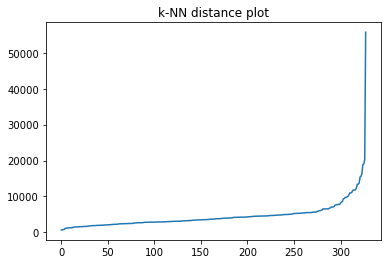

In [99]:
from sklearn.neighbors import NearestNeighbors

def k_distance_plot(df, min_samples):
    neigh = NearestNeighbors(n_neighbors=min_samples)
    nbrs = neigh.fit(df)
    distances, indices = nbrs.kneighbors(df)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.title("k-NN distance plot")
    plt.plot(distances)

k_distance_plot(data, len(data.columns) * 2)

In [100]:
eps = 21000
min_samples = len(data.columns) * 2
data_labels = DB_outliers(data, eps, min_samples)

Num Clusters:3
Size Outliers:83


### Outliers (%)

In [101]:
100 * (65 / len(data))

19.817073170731707

According to DBSCAN, our data contains 19.8% of outliers.

### Visualization of DBSCAN Clustering

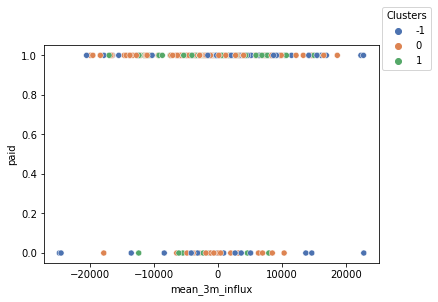

In [102]:
p = sb.scatterplot(data=data, x="mean_3m_influx", y="paid", hue=data_labels, legend="full", palette="deep")
sb.move_legend(p, "upper right", bbox_to_anchor=(1.17, 1.2), title='Clusters')
plt.show()

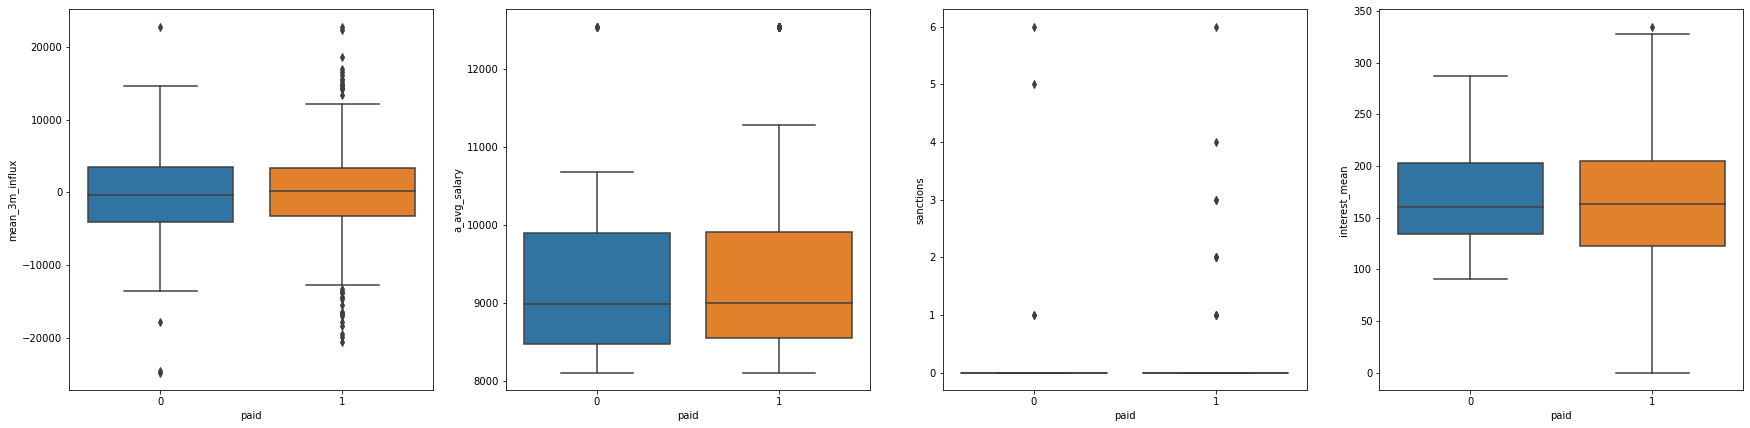

In [117]:
cols = ['mean_3m_influx', 'a_avg_salary', 'sanctions', 'interest_mean']

def box_plot(df, y, ax):
    sb.boxplot(x="paid", y=y, data=df, ax=ax)

n = len(cols)
ncols = n // 1
fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(30,7))
for i in range(n):
    box_plot(data, cols[i], axes[i])

### Create dataset without outliers

In [104]:
pure_data = data[data_labels != -1]
pure_data

,a_district,a_region,a_urban_ratio,is_co-owned,gender,age,amount,payments,balance_min,a_avg_salary,mean_3m_influx,frequency_monthly issuance,frequency_weekly issuance,paid,loan_id,sanctions,interest_mean,frequency_issuance after transaction
0,0.859756,0.801928,81.8,0,0,2,96396,8033,1100.0,9650,6333.333333,0,1,0,5314,0,128.930000,0
1,0.964939,0.923409,73.5,0,1,1,165960,4610,700.0,8369,-12278.966667,1,0,1,5316,0,118.091667,0
2,0.971951,0.923409,53.5,0,1,3,127080,2118,800.0,8390,-2448.833333,1,0,1,6863,0,193.711111,0
3,0.976626,0.808117,74.8,0,0,2,105804,2939,1000.0,10045,-990.000000,1,0,1,5325,0,252.633333,0
5,0.809959,0.891046,41.3,1,0,0,87840,3660,500.0,8598,6394.400000,1,0,1,6687,0,216.680000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,0.809959,0.963218,89.9,0,1,1,123408,5142,700.0,10446,1223.633333,0,0,1,7130,0,220.300000,1
323,0.805432,0.766534,62.6,1,0,1,155616,3242,200.0,8994,2870.900000,1,0,1,6818,0,213.500000,0
325,0.896341,0.766534,89.9,0,0,2,45024,938,800.0,10177,130.366667,1,0,1,6805,0,189.125000,0
326,0.837108,0.808117,56.9,0,1,2,115812,3217,1100.0,8427,-11088.566667,1,0,1,7233,0,163.472727,0


In [105]:
import os

PATH = '../assets/final'
FINAL_FILE_DEV = "/pure_data.csv"


if not os.path.exists(PATH):
  os.mkdir(PATH)


pure_data.to_csv(PATH + FINAL_FILE_DEV, index=False)